In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def make_generator_network(input_size=20,num_hidden_layers=1,num_hidden_units=100,num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}',nn.Linear(input_size,num_hidden_units))
        model.add_module(f'relu_g{i}',nn.LeakyReLU())
        input_size = num_hidden_units
        model.add_module(f'fc_g{num_hidden_layers}',nn.Linear(input_size,num_output_units))
        model.add_module(f'tanh_g',nn.Tanh())
        return model

def make_discriminator_network(input_size,num_hidden_layers=1,num_hidden_units=100,num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}',nn.Linear(input_size,num_hidden_units,bias=False))
        model.add_module(f'relu_d{i}',nn.LeakyReLU())
        model.add_module(f'dropout',nn.Dropout(0.5))
        input_size = num_hidden_units
        model.add_module(f'fc_d{num_hidden_layers}',nn.Linear(input_size,num_output_units))
        model.add_module(f'sigmoid',nn.Sigmoid())
        return model

In [3]:
image_size = (28,28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

In [4]:
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5),std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,train=True,transform=transform,download=True)
example,label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [5]:
def create_noise(batch_size,z_size,mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size,z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size,z_size)
    return input_z

In [8]:
batch_size = 64
mode_z = 'uniform'
mnist_dl = DataLoader(mnist_dataset,batch_size,shuffle=True,drop_last=True)
gen_model = make_generator_network(input_size=z_size,num_hidden_layers=gen_hidden_layers,num_hidden_units=gen_hidden_size,num_output_units=np.prod(image_size)).to(device)
disc_model = make_discriminator_network(input_size=np.prod(image_size),num_hidden_layers=gen_hidden_layers,num_hidden_units=gen_hidden_size).to(device)
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

def d_train(x):
    disc_model.zero_grad()
    batch_size = x.size(0)
    x = x.view(batch_size,-1).to(device)
    d_labels_real = torch.ones(batch_size,1,device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real,d_labels_real)

    input_z = create_noise(batch_size,z_size,mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size,1,device=device)
    d_loss_fake = loss_fn(d_proba_fake,d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size,z_size,mode_z).to(device)
    g_labels_real = torch.ones(batch_size,1,device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake,g_labels_real)

    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()


In [10]:
fixed_z = create_noise(batch_size,z_size,mode_z).to(device)
def create_sample(g_model,input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size,*image_size))
    return (images+1)/2.0

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1,num_epochs+1):
    d_losses, g_losses = [],[]
    d_vals_real, d_vals_fake = [],[]
    for i, (x,_) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f}'
          f' D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(create_sample(gen_model,fixed_z).detach().cpu().numpy())
    


Epoch 001 | Avg Losses > G/D 0.8697/1.1886 [D-Real: 0.5906D-Fake: 0.4503]
Epoch 002 | Avg Losses > G/D 1.0508/1.1329 [D-Real: 0.6077D-Fake: 0.4139]
Epoch 003 | Avg Losses > G/D 0.9059/1.2502 [D-Real: 0.5589D-Fake: 0.4420]
Epoch 004 | Avg Losses > G/D 0.9284/1.2191 [D-Real: 0.5744D-Fake: 0.4278]
Epoch 005 | Avg Losses > G/D 1.0318/1.1832 [D-Real: 0.5874D-Fake: 0.4080]
Epoch 006 | Avg Losses > G/D 0.9395/1.2312 [D-Real: 0.5690D-Fake: 0.4279]
Epoch 007 | Avg Losses > G/D 0.9120/1.2470 [D-Real: 0.5612D-Fake: 0.4323]
Epoch 008 | Avg Losses > G/D 1.0217/1.1815 [D-Real: 0.5912D-Fake: 0.4080]
Epoch 009 | Avg Losses > G/D 1.1010/1.1493 [D-Real: 0.6031D-Fake: 0.3959]
Epoch 010 | Avg Losses > G/D 1.0967/1.1260 [D-Real: 0.6152D-Fake: 0.3905]
Epoch 011 | Avg Losses > G/D 1.0407/1.1467 [D-Real: 0.6073D-Fake: 0.3959]
Epoch 012 | Avg Losses > G/D 1.0254/1.1641 [D-Real: 0.6018D-Fake: 0.4029]
Epoch 013 | Avg Losses > G/D 1.1035/1.1290 [D-Real: 0.6162D-Fake: 0.3889]
Epoch 014 | Avg Losses > G/D 1.0096/1.

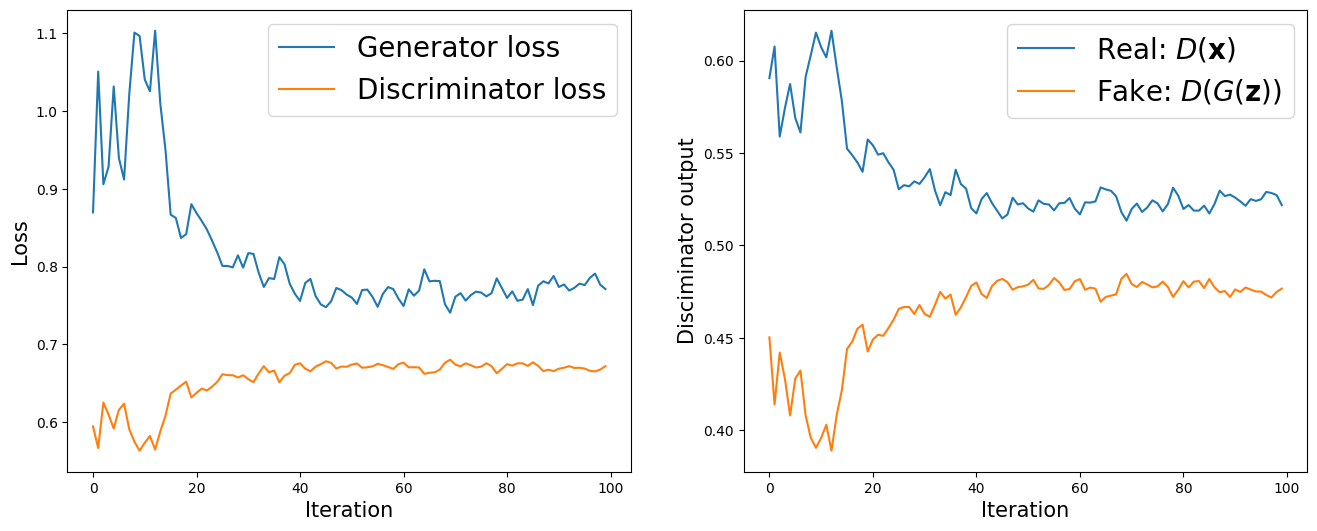

In [12]:
import itertools
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.plot(all_g_losses,label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration',size=15)
ax.set_ylabel('Loss',size=15)

ax = fig.add_subplot(1,2,2)
plt.plot(all_d_real,label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake,label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration',size=15)
ax.set_ylabel('Disciminator output',size=15)
plt.show()

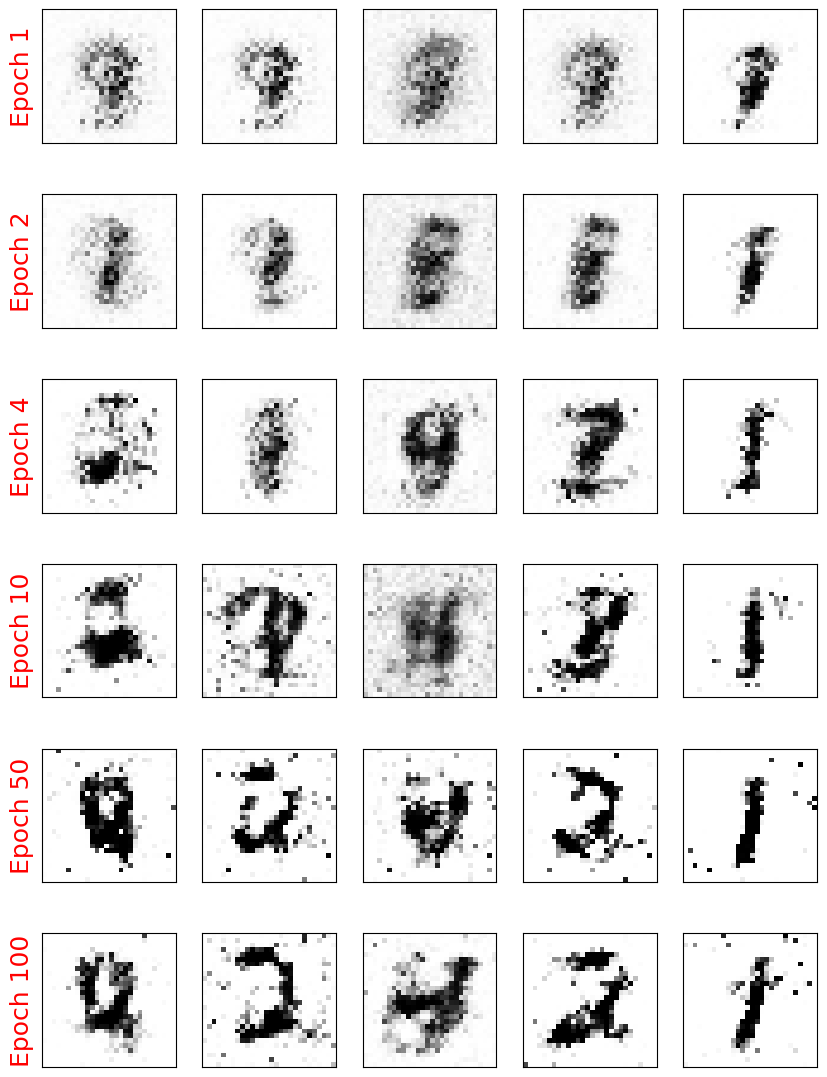

: 

In [14]:
selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10,14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6,5,i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06,0.5,f'Epoch {e}',rotation=90,size=18,color='red',horizontalalignment='right',verticalalignment='center',transform=ax.transAxes)
        image = epoch_samples[e-1][j]
        ax.imshow(image,cmap='gray_r')
plt.show()